<a href="https://colab.research.google.com/github/sibot89/kaggle/blob/main/titanic_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import SGD

In [3]:
from google.colab import files
files.upload();

Saving train.csv to train.csv


In [4]:
df_train = pd.read_csv('train.csv')
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df_train = df_train.drop(['PassengerId', 'Name'], axis=1)
df_train.shape

(891, 10)

In [6]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
num_samples, num_features = df_train.shape
num_features -= 1
num_classes = len(np.unique(df_train['Survived']))
num_samples, num_features, num_classes

(891, 9, 2)

Balancing the dataset .?.

In [8]:
df_train, df_valid = train_test_split(df_train, train_size=0.8,
                                                    random_state=42, shuffle=True, stratify=df_train['Survived'])


Dealing with missin values

In [9]:
df_train.isna().mean() * 100

,0
Survived,0.000000
Pclass,0.000000
Sex,0.000000
Age,19.241573
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000
Cabin,77.528090
Embarked,0.280899


In [10]:
missing_threshold = 0.8

high_missing_threshold = df_train.columns[df_train.isna().mean() >
                                          missing_threshold]

df_train = df_train.drop(columns=high_missing_threshold)
df_valid = df_valid.drop(columns=high_missing_threshold)

In [11]:
mode_values = df_train.mode()
mode_values = mode_values.loc[0].to_dict()

mode_values

{'Survived': 0.0,
 'Pclass': 3.0,
 'Sex': 'male',
 'Age': 22.0,
 'SibSp': 0.0,
 'Parch': 0.0,
 'Ticket': '1601',
 'Fare': 13.0,
 'Cabin': 'G6',
 'Embarked': 'S'}

In [12]:
median_values = df_train.median(numeric_only=True).to_dict()
median_values

{'Survived': 0.0,
 'Pclass': 3.0,
 'Age': 28.5,
 'SibSp': 0.0,
 'Parch': 0.0,
 'Fare': 14.4542}

In [13]:
for column in df_train.columns:
  if df_train[column].isna().any():

    if df_train[column].dtype == 'object':
      df_train[column] = df_train[column].fillna(mode_values[column])
      df_valid[column] = df_valid[column].fillna(mode_values[column])

    else:
      df_train[column] = df_train[column].fillna(median_values[column])
      df_valid[column] = df_valid[column].fillna(median_values[column])

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
692,1,3,male,28.5,0,0,1601,56.4958,G6,S
481,0,2,male,28.5,0,0,239854,0.0000,G6,S
527,0,1,male,28.5,0,0,PC 17483,221.7792,C95,S
855,1,3,female,18.0,0,1,392091,9.3500,G6,S
801,1,2,female,31.0,1,1,C.A. 31921,26.2500,G6,S


In [14]:
df_train.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,0
Embarked,0


Encoding

In [15]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [16]:
cat_cols_train = df_train.select_dtypes(include='object').columns
cat_cols_train

Index(['Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

In [17]:
df_train[cat_cols_train] = ordinal_encoder.fit_transform(df_train[cat_cols_train].astype(str))
df_valid[cat_cols_train] = ordinal_encoder.transform(df_valid[cat_cols_train].astype(str))

In [18]:
X_train = df_train.drop(['Survived'], axis=1).values
y_train = df_train['Survived'].values.reshape(-1, 1)

X_valid = df_valid.drop(['Survived'], axis=1).values
y_valid = df_valid['Survived'].values.reshape(-1, 1)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((712, 9), (712, 1), (179, 9), (179, 1))

In [19]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([712, 9]),
 torch.Size([712, 1]),
 torch.Size([179, 9]),
 torch.Size([179, 1]))

In [20]:
train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_valid, y_valid)

In [21]:
train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512)

In [241]:
nfl1 = 8 * num_features
nfl2 = 4 * num_features
nfl3 = num_features

model = nn.Sequential(
    nn.Linear(num_features, nfl1),
    nn.ReLU(),
    nn.Linear(nfl1, nfl2),
    nn.ReLU(),
    nn.Linear(nfl2, nfl3),
    nn.ReLU(),
    nn.Linear(nfl3, 1),
    nn.Sigmoid()
)
# model.to(device)

In [242]:
model[0].bias

Parameter containing:
tensor([-0.0034,  0.0538,  0.2889, -0.1937,  0.3319,  0.1385, -0.1643,  0.0185,
        -0.1678, -0.2050, -0.1744, -0.2220, -0.2517,  0.2659,  0.2951, -0.3288,
         0.1492,  0.3151, -0.1180,  0.3109,  0.2865, -0.1878,  0.2478,  0.0885,
        -0.1517, -0.2077, -0.1243,  0.2730,  0.2066,  0.1044, -0.2808,  0.0306,
         0.1932, -0.1058,  0.2340,  0.1715,  0.1025,  0.1806,  0.2847,  0.1498,
        -0.2564,  0.2803,  0.0123, -0.1689,  0.1700,  0.1883, -0.2491,  0.2527,
         0.0400,  0.1559,  0.0418,  0.2222,  0.0654, -0.2272,  0.0091,  0.0829,
         0.0161, -0.0027,  0.2471,  0.2525, -0.2764,  0.0162,  0.0468,  0.1773,
         0.0868,  0.2499, -0.1204, -0.0831,  0.2725, -0.2705, -0.3019, -0.1428],
       requires_grad=True)

In [243]:
loss_fn = nn.BCELoss()

In [244]:
optimizer = SGD(model.parameters(), lr=0.002)

In [245]:
n_epochs = 20
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []
best_loss_valid = float('inf')

In [255]:
for i in range(n_epochs):
  mean_loss_train, mean_loss_valid = 0, 0
  mean_acc_train, mean_acc_valid = 0, 0
  for x_batch , y_batch in train_loader:
    # x_batch = x_batch.to(device)
    # y_batch = y_batch.to(device)

    y_hat = model(x_batch)

    loss = loss_fn(y_hat, y_batch)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    mean_loss_train += loss.item() * len(x_batch)
    mean_acc_train += torch.sum(y_hat.round() == y_batch).item()

  mean_loss_train = mean_loss_train/len(train_set)
  mean_acc_train = mean_acc_train/len(train_set)

  loss_train_hist.append(mean_loss_train)
  acc_train_hist.append(mean_acc_train)

  with torch.no_grad():
    for x_batch , y_batch in valid_loader:
      # x_batch = x_batch.to(device)
      # y_batch = y_batch.to(device)

      y_hat = model(x_batch)
      loss = loss_fn(y_hat, y_batch)
      mean_loss_valid += loss.item() * len(x_batch)
      mean_acc_valid += torch.sum(y_hat.round() == y_batch).item()

    mean_loss_valid = mean_loss_valid/len(valid_set)
    mean_acc_valid = mean_acc_valid/len(valid_set)

    loss_valid_hist.append(mean_loss_valid)
    acc_valid_hist.append(mean_acc_valid)

  print(f"epoch: {i}  "
      f"TrainLoss: {mean_loss_train:.2}  "
      f"TrainAcc: {mean_acc_train:.2}  "
      f"ValidLoss: {mean_loss_valid:.2}  "
      f"ValidAcc: {mean_acc_valid:.2}")
  if mean_loss_valid < best_loss_valid:
    torch.save(model, "best-model.pt")
    best_loss_valid = mean_loss_valid
    print(f"Model Saved! best loss valid: {best_loss_valid}")
    print()

epoch: 0  TrainLoss: 0.59  TrainAcc: 0.71  ValidLoss: 0.69  ValidAcc: 0.64
epoch: 1  TrainLoss: 0.59  TrainAcc: 0.7  ValidLoss: 0.69  ValidAcc: 0.64
epoch: 2  TrainLoss: 0.58  TrainAcc: 0.7  ValidLoss: 0.69  ValidAcc: 0.64
epoch: 3  TrainLoss: 0.58  TrainAcc: 0.7  ValidLoss: 0.69  ValidAcc: 0.63
epoch: 4  TrainLoss: 0.58  TrainAcc: 0.71  ValidLoss: 0.69  ValidAcc: 0.64
epoch: 5  TrainLoss: 0.58  TrainAcc: 0.71  ValidLoss: 0.69  ValidAcc: 0.63
epoch: 6  TrainLoss: 0.58  TrainAcc: 0.71  ValidLoss: 0.69  ValidAcc: 0.63
epoch: 7  TrainLoss: 0.58  TrainAcc: 0.71  ValidLoss: 0.69  ValidAcc: 0.63
epoch: 8  TrainLoss: 0.58  TrainAcc: 0.71  ValidLoss: 0.69  ValidAcc: 0.64
epoch: 9  TrainLoss: 0.58  TrainAcc: 0.71  ValidLoss: 0.69  ValidAcc: 0.64
epoch: 10  TrainLoss: 0.58  TrainAcc: 0.71  ValidLoss: 0.69  ValidAcc: 0.63
epoch: 11  TrainLoss: 0.58  TrainAcc: 0.71  ValidLoss: 0.69  ValidAcc: 0.64
epoch: 12  TrainLoss: 0.58  TrainAcc: 0.71  ValidLoss: 0.68  ValidAcc: 0.63
epoch: 13  TrainLoss: 0.5

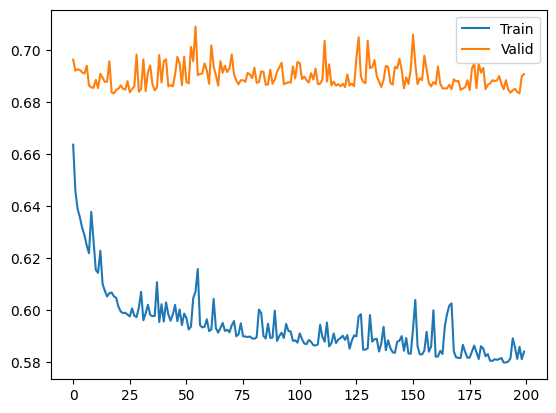

In [256]:
plt.plot(loss_train_hist)
plt.plot(loss_valid_hist)
plt.legend(['Train', 'Valid'])

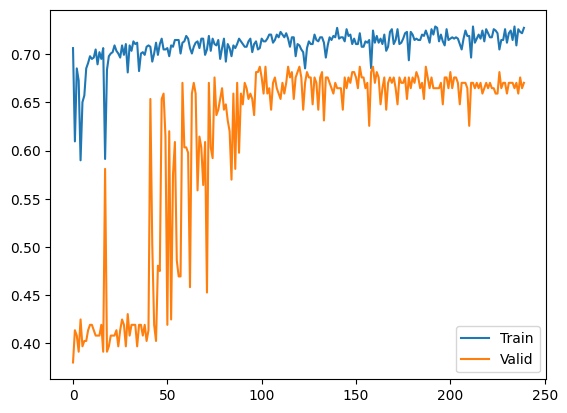

In [233]:
plt.plot(acc_train_hist)
plt.plot(acc_valid_hist)
plt.legend(['Train', 'Valid'])

In [29]:
files.upload();

Saving test.csv to test.csv


In [30]:
df_test = pd.read_csv('test.csv')
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [31]:
df_test = df_test.drop(['PassengerId', 'Name'], axis=1)
df_test.shape

(418, 9)

In [32]:
df_test = df_test.drop(columns=high_missing_threshold)


In [33]:
for column in df_test.columns:
  if df_test[column].isna().any():

    if df_test[column].dtype == 'object':
      df_test[column] = df_test[column].fillna(mode_values[column])

    else:
      df_test[column] = df_test[column].fillna(median_values[column])

df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,34.5,0,0,330911,7.8292,G6,Q
1,3,female,47.0,1,0,363272,7.0000,G6,S
2,2,male,62.0,0,0,240276,9.6875,G6,Q
3,3,male,27.0,0,0,315154,8.6625,G6,S
4,3,female,22.0,1,1,3101298,12.2875,G6,S


In [34]:
df_test[cat_cols_train] = ordinal_encoder.transform(df_test[cat_cols_train].astype(str))

In [35]:
df_test.shape

(418, 9)

In [40]:
test_set = torch.tensor(df_test.values, dtype=torch.float32)

In [38]:
best_model = torch.load("best-model.pt", weights_only=False)
best_model

Sequential(
  (0): Linear(in_features=9, out_features=18, bias=True)
  (1): ReLU()
  (2): Linear(in_features=18, out_features=1, bias=True)
  (3): Sigmoid()
)

In [43]:
predictions = best_model(test_set)

In [1]:
survived_prediction = predictions.round().int()
survived_prediction

NameError: name 'predictions' is not defined

In [ ]:
with open("./results.csv", mode=w) as myFile:
  myFile.write(survived_prediction)